# Notebook for modeling nyiso forecast error based on twitter during sandy.

In [1]:
%matplotlib inline
import sys
import os
sys.path.append(os.path.abspath('../'))

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from math import cos, sin
import numpy as np
import pandas as pd
import scipy.signal
import scipy.stats
import seaborn as sns
sns.set()
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

from twitterinfrastructure.tools import boxcox_backtransform, cross_corr, \
    output
import twitterinfrastructure.analysis as asys
import twitterinfrastructure.nyiso as pw
import twitterinfrastructure.twitter_sandy as ts

import importlib
importlib.reload(asys)
importlib.reload(pw)
importlib.reload(ts)

#os.chdir('../')
print(os.getcwd())

matplotlib.rc('text', usetex=True)
matplotlib.rc('font', **{'family': "serif"})
params = {'text.latex.preamble': [r'\usepackage{siunitx}', 
                                  r'\usepackage{amsmath}']}
plt.rcParams.update(params)
sns.set_context('paper')
# sns.set_context('talk')
sns.set_style('darkgrid')

C:\dev\research\socialsensing\notebooks


## Load data.

Loads Sandy-related tweets and load forecast error data (grouped by hour-zone). Loading takes ~1 minute.

In [25]:
# load data
tweet_count_filter = 5  # by day
db_path = 'data/processed/nyiso-2012.db'
startdate = pd.Timestamp('2012-10-28 00:00:00', 
                         tz='America/New_York')  # inclusive
enddate = pd.Timestamp('2012-11-03 00:00:00', 
                       tz='America/New_York')  # exclusive

# load nyiso load data (filtered by dates, grouped by zone-hour)
df_load = asys.load_nyiso(startdate, enddate, db_path, verbose=1)

# load normalized sandy-related tweets (filtered by dates, grouped by zone-hour)
df_tweets = ts.query_groupby_hour_norm('tweets_sandy', 'tweets_analysis', 
                                       'nyiso_zone', tweet_count_filter, 
                                       startdate=startdate, enddate=enddate, 
                                       verbose=2)
df_tweets = df_tweets.rename(columns={'tweets': 'sandy-tweets', 
                                      'tweets-norm': 'sandy-tweets-norm'})

# combine into one dataframe
df_tweets.index.names = ['nyiso_zone', 'datetimeNY']    # temp (merge)
df_tweets = df_tweets.rename(index={'A': 1, 'B': 2, 'C': 3, 'D': 4,
                                    'E': 5, 'F': 6, 'G': 7, 'H': 8,
                                    'I': 9, 'J': 10, 'K': 11})
df = pd.merge(df_load, df_tweets, how='left', left_index=True, right_index=True)

# replace infinite values with nan
df = df.replace([np.inf, -np.inf], np.nan)

# export hourly dataframe to csv
# print('Dataframe rows: ' + str(df.shape[0]))
# path = 'data/processed/nyisosummary_zone_hour.csv'
# df.to_csv(path, index_label=['zone', 'datetimeNY'])

# print zone counts with nans removed (10: 120, 11: 98, ...)
y1 = 'sandy-tweets-norm'
y2 = 'err0'
df_na = df[[y1, y2]].dropna()
counts = df_na.count(level='nyiso_zone')[y1]
counts = counts.sort_values(ascending=False)
counts = counts.rename('number of non-nan data points per zone')
print(counts)
print('')

2018-10-09 21:42:17 : Started query.

2018-10-09 21:42:17 : [min, max] forecast error datetimeNY: [2012-10-28 00:00:00-04:00, 2012-11-02 23:00:00-04:00].

2018-10-09 21:42:17 : [min, max] forecast error: [-0.3133047210300429, 3.3987975951903806].

2018-10-09 21:42:17 : Finished query.

2018-10-09 21:42:17 : Started query.

2018-10-09 21:42:17 : Started query.

2018-10-09 21:42:18 : [min, max] tweets datetime from tweets_sandy: [2012-10-28 00:00:00-04:00, 2012-11-02 00:00:00-04:00].

2018-10-09 21:42:18 : [min, max] number of tweets from tweets_sandy: [5, 780].

2018-10-09 21:42:18 : Finished query.

2018-10-09 21:42:18 : Started query.

2018-10-09 21:42:21 : [min, max] tweets datetime from tweets_analysis: [2012-10-28 00:00:00-04:00, 2012-11-02 00:00:00-04:00].

2018-10-09 21:42:21 : [min, max] number of tweets from tweets_analysis: [5, 3259].

2018-10-09 21:42:21 : Finished query.

2018-10-09 21:42:21 : [min, max] tweets norm: [0.009746588693957114], 0.3125].

2018-10-09 21:42:21 : Fi

In [26]:
# load timedelta, timeseries, and shifted timeseries data
# load timedelta data (indexed by timedelta from landing)
datetime_ref = pd.Timestamp('2012-10-30 20:00:00', tz='America/New_York')
df_td = df[[y1, y2]]
df_td = asys.index_timedelta(df_td, datetime_ref, 'datetimeNY')

# load timeseries data (linearly interpolated over the max range of 
# timedeltas for each parameter of each zone, only series with at least 
# min_count data points are included)
min_count = 20
df_ts = asys.create_timeseries(df_td, 'nyiso_zone', min_count,
                               write_path=None, verbose=2)

# calculate time shift (on power) that maximizes cross-correlation for each zone
shifts = list(reversed(range(-48, 1)))    # [hours]
min_overlap = 20
df_max_rho, _ = asys.max_cross_corr(df_ts, y1, y2, 'nyiso_zone', shifts, 
                                    min_overlap, verbose=2)
print(df_max_rho)

# load shifted timeseries dataframe (using shift on power that maximizes ccr)
df_ts_shift = asys.create_timeseries_shift(df_ts, df_max_rho, y1, y2, 
                                           'nyiso_zone', write_path=None)
df_ts_shift.head()

2018-10-09 21:42:37 : skipped zones for having less than 20 data points in original column data: [(4, 'sandy-tweets-norm'), (8, 'sandy-tweets-norm')]



<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th></th>
      <th>sandy-tweets-norm</th>
      <th>err0</th>
    </tr>
    <tr>
      <th>nyiso_zone</th>
      <th>timedelta</th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th rowspan="5" valign="top">1</th>
      <th>-3 days +04:00:00</th>
      <td>NaN</td>
      <td>0.000689</td>
    </tr>
    <tr>
      <th>-3 days +05:00:00</th>
      <td>NaN</td>
      <td>-0.006048</td>
    </tr>
    <tr>
      <th>-3 days +06:00:00</th>
      <td>NaN</td>
      <td>-0.015645</td>
    </tr>
    <tr>
      <th>-3 days +07:00:00</th>
      <td>NaN</td>
      <td>-0.017371</td>
    </tr>
    <tr>
      <th>-3 days +08:00:00</th>
      <td>NaN</td>
      <td>-0.011928</td>
    </tr>
  </tbody>
</table>
</div>

In [28]:
# load differenced timeseries data
df_ts_diff = asys.create_timeseries_diff(df_ts, y1, y2, 'nyiso_zone',
                                         write_path=None)

# calculate time shift (on diff power) that maximizes cross-correlation for 
# each zone
shifts = list(reversed(range(-48, 1)))    # [hours]
min_overlap = 20
df_max_rho_diff, _ = asys.max_cross_corr(df_ts_diff, y1, y2, 'nyiso_zone',
                                         shifts, min_overlap, verbose=2)
print(df_max_rho_diff)

# load shifted timeseries dataframe (using shift on power that maximizes ccr)
df_ts_diff_shift = asys.create_timeseries_shift(df_ts_diff, df_max_rho_diff, 
                                                y1, y2, 'nyiso_zone', 
                                                write_path=None)
df_ts_diff_shift.head()

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th></th>
      <th>err0</th>
      <th>sandy-tweets-norm</th>
    </tr>
    <tr>
      <th>nyiso_zone</th>
      <th>timedelta</th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th rowspan="5" valign="top">1</th>
      <th>-3 days +04:00:00</th>
      <td>-0.006737</td>
      <td>NaN</td>
    </tr>
    <tr>
      <th>-3 days +05:00:00</th>
      <td>-0.009598</td>
      <td>NaN</td>
    </tr>
    <tr>
      <th>-3 days +06:00:00</th>
      <td>-0.001725</td>
      <td>NaN</td>
    </tr>
    <tr>
      <th>-3 days +07:00:00</th>
      <td>0.005443</td>
      <td>NaN</td>
    </tr>
    <tr>
      <th>-3 days +08:00:00</th>
      <td>0.002833</td>
      <td>NaN</td>
    </tr>
  </tbody>
</table>
</div>

## Plot data.

TODO
- look for ways to handle the trend and seaonality/cyclic nature of timeseries data (e.g. see [here](https://otexts.org/fpp2/autocorrelation.html))

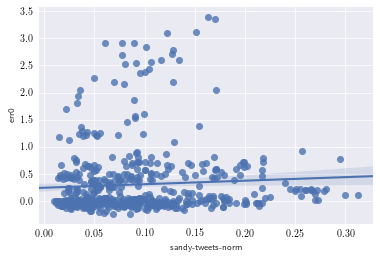

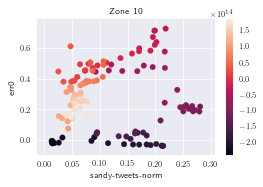

In [49]:
# timedelta plots
# scatterplot
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=False)
ax = sns.regplot(y1, y2,
                 data=df_td, fit_reg=True,
                 scatter_kws={'marker': 'D', 's': 50},
                 ax=ax)
ax.tick_params(axis='both', colors='k')
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel(y1)
ax.set_ylabel(y2)
# ax.set_xlabel(r'log($SN_{i,t}$)', color='k', size=12)
# ax.set_ylabel(r'log($\langle | z\textnormal{-drop}_{i,t} | \rangle$)', 
#               color='k', size=12)
# plt.savefig('notebooks/images/report/taxi-totalcorrelation.png', dpi=150, 
#             bbox_inches='tight')

# scatterplot by zone
# zones = pd.unique(df_ts.index.get_level_values(level='nyiso_zones'))
zones = [10]
for zone in zones:
    df_zone = df_td.xs(zone, level=0)
    y1_s = df_zone[y1]
    y2_s = df_zone[y2]

    # scatterplot
    fig, ax = plt.subplots(figsize=(4, 2.5), tight_layout=False)
    sc = ax.scatter(y1_s, y2_s, c=df_zone.index.values)
    plt.colorbar(sc)
    ax.set_xlabel(y1)
    ax.set_ylabel(y2)
    plt.title('Zone {z}'.format(z=zone))

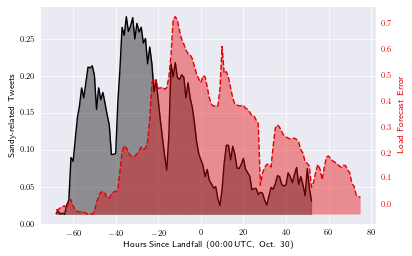

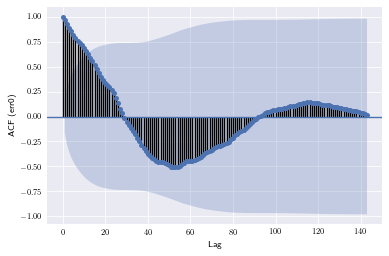

In [32]:
# timeseries plots
# zones = pd.unique(df_ts.index.get_level_values(level='nyiso_zones'))
zones = [10]
for zone in zones:
    # get data
    s1 = df_ts[y1].xs(zone, level='nyiso_zone').dropna()
    s2 = df_ts[y2].xs(zone, level='nyiso_zone').dropna()
    
    # plot tweets and err0 time series
    asys.plot_timeseries(s1, s2, 
                         figsize=(6, 4),
                         xlabel=r'Hours Since Landfall (00:00 UTC, Oct. 30)',
                         y1label=r'Sandy-related Tweets',
                         y2label=r'Load Forecast Error',
                         save_path=None)

    # plot ACF
    asys.plot_acf_series(s2, figsize=(6, 4), save_path=None)

    # # plot err0 and err0 (box-cox)
    # vals, lmbda = scipy.stats.boxcox(s2.values + 1, lmbda=None)
    # s2_boxcox = pd.Series(data=vals, index=s2.index.values)
    # asys.plot_timeseries(s2, s2_boxcox, 
    #                      figsize=(6, 4),
    #                      xlabel=r'Hours Since Landfall (00:00 UTC, Oct. 30)',
    #                      y1label=r'Load Forecast Error',
    #                      y2label=r'Load Forecast Error (Box-Cox, '
    #                              r'$\lambda$={lmbda}'.format(
    #                          lmbda=round(lmbda, 2)),
    #                      save_path=None)
    # output('lambda (box-cox): {lmbda}'.format(lmbda=lmbda))

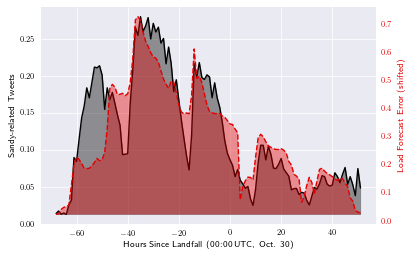

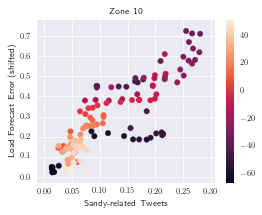

In [37]:
# shifted timeseries plots
# zones = pd.unique(df_ts_shift.index.get_level_values(level='nyiso_zone'))
zones = [10]
for zone in zones:
    # get data
    # s1 = df_ts_shift[y1].xs(zone, level='nyiso_zone').dropna()
    # s2 = df_ts_shift[y2].xs(zone, level='nyiso_zone').dropna()
    df_zone = df_ts_shift.xs(zone, level='nyiso_zone').dropna()
    s1 = df_zone[y1]
    s2 = df_zone[y2]

    # save_path = 'notebooks/images/ciri/nyiso-' \
    #             '{zone}-timeseries-maxccr.png'.format(zone=zone) 
    asys.plot_timeseries(s1, s2, 
                         figsize=(6, 4),
                         xlabel=r'Hours Since Landfall (00:00 UTC, Oct. 30)',
                         y1label=r'Sandy-related Tweets',
                         y2label=r'Load Forecast Error (shifted)',
                         save_path=None)
    
    # scatterplot
    fig, ax = plt.subplots(figsize=(4, 3), tight_layout=False)
    x1 = [int(td.total_seconds() / 3600) for td in s1.index]
    sc = ax.scatter(s1.values, s2.values, c=x1)
    plt.colorbar(sc)
    ax.set_xlabel(r'Sandy-related Tweets')
    ax.set_ylabel(r'Load Forecast Error (shifted)')
    plt.title('Zone {z}'.format(z=zone))

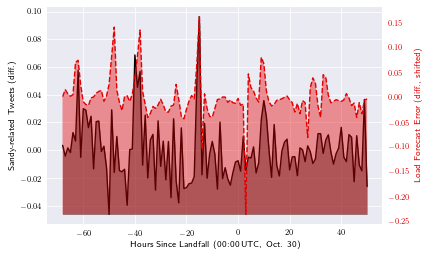

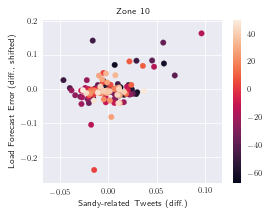

In [40]:
# shifted differenced timeseries plots
# zones = pd.unique(df_ts_shift.index.get_level_values(level='nyiso_zone'))
zones = [10]
for zone in zones:
    # get data
    df_zone = df_ts_diff_shift.xs(zone, level='nyiso_zone').dropna()
    s1 = df_zone[y1]
    s2 = df_zone[y2]

    # save_path = 'notebooks/images/ciri/nyiso-' \
    #             '{zone}-timeseries-maxccr.png'.format(zone=zone) 
    asys.plot_timeseries(s1, s2, 
                         figsize=(6, 4),
                         xlabel=r'Hours Since Landfall (00:00 UTC, Oct. 30)',
                         y1label=r'Sandy-related Tweets (diff.)',
                         y2label=r'Load Forecast Error (diff., shifted)',
                         save_path=None)
    
    # scatterplot
    fig, ax = plt.subplots(figsize=(4, 3), tight_layout=False)
    x1 = [int(td.total_seconds() / 3600) for td in s1.index]
    sc = ax.scatter(s1.values, s2.values, c=x1)
    plt.colorbar(sc)
    ax.set_xlabel(r'Sandy-related Tweets (diff.)')
    ax.set_ylabel(r'Load Forecast Error (diff., shifted)')
    plt.title('Zone {z}'.format(z=zone))

## Analyze models.

Best MLR model seems to be with a Box-Cox transform (auto lambda, no shift) on shifted timeseries data.

MLR seems to have trouble with differenced shifted timeseries prediction, due to some large difference in errors that are not captured in tweets.

TODO
- look at dynamic regression (e.g. [here](https://otexts.org/fpp2/dynamic.html))

zone 10 box-cox back-transform check (lambda, shift): 0.5122576831502759, 0
box-cox back transform err: 2.2551405187698492e-15


Zone 10
Coefficients: 
 [ 1.66086219  0.00886608  0.01784897 -0.00871564 -0.02713812]
MSE: 0.005126558022154238
R2: 0.8366390618789776
Mean abs(residual): 0.057663020959616354
Median abs(residual): 0.04600207854082944


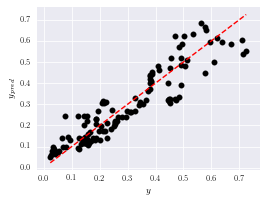

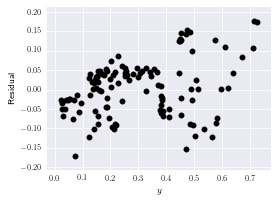

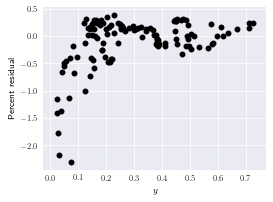

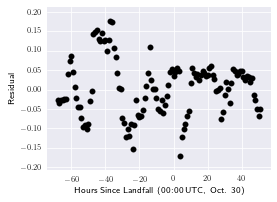

In [42]:
# create regression model of shifted time series for individual zones
# pred = 'err0'
pred = 'err0-boxcox'
lmbda = None
boxcox_shift = 0
# pred = 'err0-sq'
# pred = 'err0-ln'

# define potential features
df_reg = df_ts_shift.reset_index().copy()
df_reg = df_reg.set_index('nyiso_zone')
df_reg['timedelta-h'] = [int(td.total_seconds() / 3600) for td 
                         in df_reg['timedelta']]
df_reg['td-pos'] = df_reg['timedelta-h'] + 100
df_reg['td-pos-break'] = [max(0, 72 - td_pos) for td_pos in df_reg['td-pos']]
df_reg['datetimeNY'] = datetime_ref + df_reg['timedelta']
df_reg['hour'] = df_reg['datetimeNY'].dt.hour
df_reg['hour-sin'] = df_reg['hour'].apply(sin)
df_reg['hour-cos'] = df_reg['hour'].apply(cos)

# create zonal regression models
# zones = pd.unique(df_reg.index)
zones = [10]
for zone in zones:
    df_zone = df_reg.loc[zone].dropna()
    y = df_zone['err0'].values
    
    # apply possible transformations
    if pred == 'err0-boxcox':
        if lmbda is None:
            y_trans, lmbda = scipy.stats.boxcox(y +
                                                boxcox_shift, lmbda=lmbda)
        else:
            y_trans = scipy.stats.boxcox(df_zone['err0'].values +
                                         boxcox_shift, lmbda=lmbda)
        df_zone[pred] = y_trans
        
        # shift backtransform check
        print('zone {zone} box-cox back-transform check (lambda, shift): '
              '{lmbda}, {shift}'.format(zone=zone, lmbda=lmbda,
                                        shift=boxcox_shift))
        y_backtrans = np.subtract(boxcox_backtransform(
            y_trans, lmbda=lmbda), boxcox_shift)
        err = sum(df_zone['err0'].values - y_backtrans)
        print('box-cox back transform err: {err}'.format(err=err))
        print('')
    elif pred == 'err0-sq':
        y_trans = [val**2 for val in df_reg['err0']]
    elif pred == 'err0-ln':
        y_trans = np.log(df_reg['err0'] + 1)
    else:
        y_trans = y
    
    # define features and targets
    X_train = df_zone[['sandy-tweets-norm', 'hour-sin', 'hour-cos',
                       'td-pos', 'td-pos-break']].values
    y_train = y_trans
    # X_train = df_zone[['sandy-tweets-norm', 'hour-sin', 'hour-cos']].values
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,
    #                                                     random_state=1)

    # fit model
    # reg.fit(X_train, y_train)
    # y_pred = reg.predict(X_test)
    reg = linear_model.LinearRegression()
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_train)
    if pred == 'err0-boxcox':
        y_pred_backtrans = np.subtract(boxcox_backtransform(
            y_pred, lmbda=lmbda), boxcox_shift)
    elif pred == 'err0-sq':
        print('NOT DONE YET')
        y_pred_backtrans = y_pred
    elif pred == 'err0-ln':
        print('NOT DONE YET')
        y_pred_backtrans = [np.e ** val - 1 for val in y_pred]
    else:
        y_pred_backtrans = y_pred

    # fit results
    print('')
    print('Zone {zone}'.format(zone=zone))
    print('Coefficients: \n', reg.coef_)
    print('MSE: {mse}'.format(mse=mean_squared_error(y, y_pred_backtrans)))
    print('R2: {r2}'.format(r2=r2_score(y, y_pred_backtrans)))
    residuals = y - y_pred_backtrans
    residuals_percent = residuals / y
    print('Mean abs(residual): {mean_abs_residual}'.format(
        mean_abs_residual=np.mean(abs(residuals))))
    print('Median abs(residual): {med_abs_residual}'.format(
        med_abs_residual=np.median(abs(residuals))))

    # Plot y_pred vs. y
    fig, ax = plt.subplots(figsize=(4, 3), tight_layout=False)
    plt.scatter(y, y_pred_backtrans,  color='black')
    plt.plot([min(y), max(y)], [min(y), max(y)], color='red', linestyle='--')
    ax.set_xlabel(r'$y$', color='k')
    ax.set_ylabel(r'$y_{pred}$', color='k')

    # Plot residuals
    fig, ax = plt.subplots(figsize=(4, 3), tight_layout=False)
    plt.scatter(y, residuals,  color='black')
    ax.set_xlabel(r'$y$', color='k')
    ax.set_ylabel(r'Residual', color='k')
    
    # Plot percent residuals
    fig, ax = plt.subplots(figsize=(4, 3), tight_layout=False)
    plt.scatter(y, residuals_percent,  color='black')
    ax.set_xlabel(r'$y$', color='k')
    ax.set_ylabel(r'Percent residual', color='k')

    # Plot residuals vs. time
    fig, ax = plt.subplots(figsize=(4, 3), tight_layout=False)
    x = [int(td.total_seconds() / 3600) for td in df_zone['timedelta']]
    plt.scatter(x, residuals,  color='black')
    ax.set_xlabel('Hours Since Landfall (00:00 UTC, Oct. 30)', color='k')
    ax.set_ylabel(r'Residual', color='k')

2018-10-09 22:15:03 : Min y: -0.23771361034283436

zone 10 box-cox back-transform check (lambda, shift): 1.6318556769024435, 1
box-cox back transform err: -4.85722573273506e-17


Zone 10
Coefficients: 
 [ 8.22170234e-01 -8.53560469e-03  4.71066185e-04 -7.30429533e-05
  3.37212780e-04]
MSE: 0.0014417874781870565
R2: 0.22536322591221158


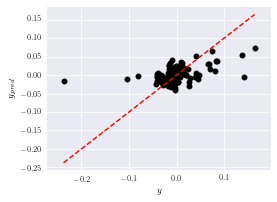

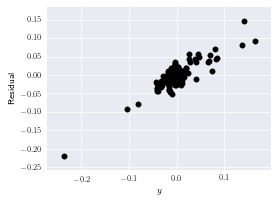

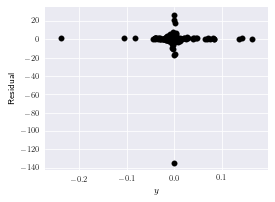

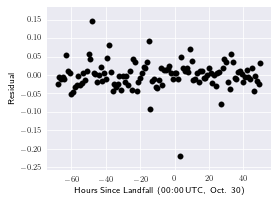

In [55]:
# create regression model of shifted difference time series for individual zones
# pred = 'err0'
pred = 'err0-boxcox'
lmbda = None
boxcox_shift = 1
# pred = 'err0-sq'
# pred = 'err0-ln'

# define potential features
df_reg = df_ts_diff_shift.reset_index().copy()
df_reg = df_reg.set_index('nyiso_zone')
df_reg['timedelta-h'] = [int(td.total_seconds() / 3600) for td 
                         in df_reg['timedelta']]
df_reg['td-pos'] = df_reg['timedelta-h'] + 100
df_reg['td-pos-break'] = [max(0, 72 - td_pos) for td_pos in df_reg['td-pos']]
df_reg['datetimeNY'] = datetime_ref + df_reg['timedelta']
df_reg['hour'] = df_reg['datetimeNY'].dt.hour
df_reg['hour-sin'] = df_reg['hour'].apply(sin)
df_reg['hour-cos'] = df_reg['hour'].apply(cos)

# create zonal regression models
# zones = pd.unique(df_reg.index)
zones = [10]
for zone in zones:
    df_zone = df_reg.loc[zone].dropna()
    y = df_zone['err0'].values

    # apply possible transformations
    if pred == 'err0-boxcox':
        output('Min y: ' + str(min(y)))
        if lmbda is None:
            y_trans, lmbda = scipy.stats.boxcox(y +
                                                boxcox_shift, lmbda=lmbda)
        else:
            y_trans = scipy.stats.boxcox(y +
                                         boxcox_shift, lmbda=lmbda)
        df_zone[pred] = y_trans

        # shift backtransform check
        print('zone {zone} box-cox back-transform check (lambda, shift): '
              '{lmbda}, {shift}'.format(zone=zone, lmbda=lmbda,
                                        shift=boxcox_shift))
        y_backtrans = np.subtract(boxcox_backtransform(
            y_trans, lmbda=lmbda), boxcox_shift)
        err = sum(y - y_backtrans)
        print('box-cox back transform err: {err}'.format(err=err))
        print('')
    elif pred == 'err0-sq':
        y_trans = [val**2 for val in y]
    elif pred == 'err0-ln':
        y_trans = np.log(y + 1)
    else:
        y_trans = y

    # define features and targets
    X_train = df_zone[['sandy-tweets-norm', 'hour-sin', 'hour-cos',
                       'td-pos', 'td-pos-break']].values
    y_train = y_trans

    # fit model
    reg = linear_model.LinearRegression()
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_train)
    if pred == 'err0-boxcox':
        y_pred_backtrans = np.subtract(boxcox_backtransform(
            y_pred, lmbda=lmbda), boxcox_shift)
    elif pred == 'err0-sq':
        y_pred_backtrans = y_pred
    elif pred == 'err0-ln':
        y_pred_backtrans = [np.e ** val - 1 for val in y_pred]
    else:
        y_pred_backtrans = y_pred

    # fit results
    print('')
    print('Zone {zone}'.format(zone=zone))
    print('Coefficients: \n', reg.coef_)
    print('MSE: {mse}'.format(mse=mean_squared_error(y, y_pred_backtrans)))
    print('R2: {r2}'.format(r2=r2_score(y, y_pred_backtrans)))

    # Plot y_pred vs. y
    fig, ax = plt.subplots(figsize=(4, 3), tight_layout=False)
    plt.scatter(y, y_pred_backtrans,  color='black')
    plt.plot([min(y), max(y)], [min(y), max(y)], color='red', linestyle='--')
    ax.set_xlabel(r'$y$', color='k')
    ax.set_ylabel(r'$y_{pred}$', color='k')

    # Plot residuals
    fig, ax = plt.subplots(figsize=(4, 3), tight_layout=False)
    plt.scatter(y, y - y_pred_backtrans,  color='black')
    ax.set_xlabel(r'$y$', color='k')
    ax.set_ylabel(r'Residual', color='k')

    # Plot percent residuals
    fig, ax = plt.subplots(figsize=(4, 3), tight_layout=False)
    plt.scatter(y, (y - y_pred_backtrans) / y,  color='black')
    ax.set_xlabel(r'$y$', color='k')
    ax.set_ylabel(r'Residual', color='k')

    # Plot residuals vs. time
    fig, ax = plt.subplots(figsize=(4, 3), tight_layout=False)
    x = [int(td.total_seconds() / 3600) for td in df_zone['timedelta']]
    plt.scatter(x, y - y_pred_backtrans,  color='black')
    ax.set_xlabel('Hours Since Landfall (00:00 UTC, Oct. 30)', color='k')
    ax.set_ylabel(r'Residual', color='k')